In [165]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np
from line_profiler import LineProfiler
from contextlib import redirect_stdout
jax.config.update("jax_enable_x64", True)

### THE ITERATION PARAMETERs
#physical parameters
delta = 0.012 #interface width
Lambda = delta/(2*jnp.sqrt(2))

gamma_ab = 1e-2 #interface energy between components A,B
gamma_bc = 1e-2
gamma_ca = 1e-2
gamma = jnp.array([gamma_ab, gamma_bc, gamma_ca])

Aa = (9*gamma_ab + 12*(gamma_ca - gamma_bc))/(4*jnp.sqrt(2)*Lambda)
Ab = (9*gamma_ab - 12*(gamma_ca - gamma_bc))/(4*jnp.sqrt(2)*Lambda)
Ac = 3*jnp.sqrt(2)*gamma_ca/Lambda - 4*Aa/3 - Ab/3
A = jnp.array([Aa, Ab, Ac])

C = jnp.max(A + jnp.roll(A, 1))/6

print(jnp.sqrt(2)*Lambda*(Aa + Ab + 2*C)/6)
print(jnp.sqrt(2)*Lambda*(Ac + Ab + 2*C)/6)
print(jnp.sqrt(2)*Lambda*(Aa + Ac + 2*C)/6)
#mean concentration of phase C
mean_uc = 9.62e-2

#numerical parameters
stepmax = 50000 # max number of iterations
tol = 5e-8 # parameter used as stopping criterion
h = 5e-6 # time-step (limited by the ODE step but independent of n1)
N = 512 #num of nodes
eps = 1e-14 #用于处理在计算化学势时P约等于0所引起的numerical error

#meshigird
l = 1
dr = l/N
r = jnp.linspace(0, l, N+1)
r_mid = (r[1:] + r[:-1]) / 2
#频率空间的网格
k = 2*jnp.pi*jnp.fft.fftfreq(N, d=dr)
print(k.shape)

0.010000000000000002
0.010000000000000005
0.010000000000000005
(512,)


True


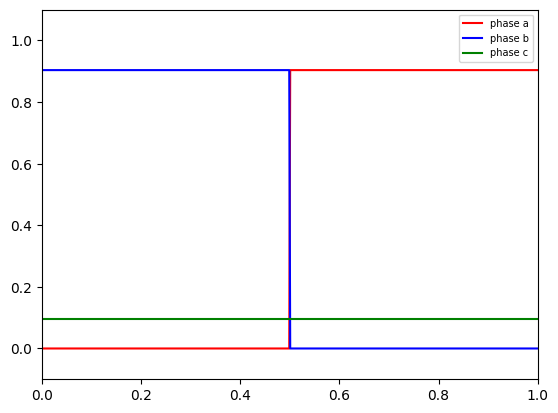

In [166]:
#the initial profile
def initial(x_interface):
    uc = jnp.full(N, mean_uc)
    ua = jnp.full(N, 1 - mean_uc)
    ub = jnp.full(N, 1 - mean_uc)
    check_a = r_mid<x_interface
    check_b = r_mid>x_interface
    ua = jnp.where(check_a, 0, ua)
    ub = jnp.where(check_b, 0, ub)
    return ua, ub, uc

def concentration_profile(ua, ub, uc, gottitle, issavefig, show):
    plt.figure(1)
    plt.plot(r_mid, ua, 'r', label="phase a")
    plt.plot(r_mid, ub, 'b', label="phase b")
    plt.plot(r_mid, uc, 'g', label="phase c")
    plt.legend(fontsize=7)
    if gottitle==True: plt.title(f"final concentration profiles with initial phi-c {mean_uc}")
    plt.xlim(0, 1)
    plt.ylim(-0.1, 1.1)
    if issavefig == True: pass
        #plt.savefig(f"result-{method}/result-c_uniform-{c_uniform}/concentration_profile_2D_{method}_{c_uniform}.png")
    if show == True: plt.show()


ua, ub, uc = initial(x_interface=0.5)
print(jnp.all(ua + ub + uc == 1))#判断全空间上三个组分的浓度是否和为1
concentration_profile(ua, ub, uc, gottitle=False, issavefig=False, show=True)

In [167]:
#compute the interface chemical potential
@jax.jit
def cal_ChemicalPotential(i, u, S, P):#u为某一组分i的浓度profile
    mu = 2*A[i]*u*(1 - u)*(1 - 2*u) + 2*C*(u*(S - u**2) - (1-u)*(P + eps)/(jnp.power(1-u, 2) + eps))
    return mu

#FFT to Fourier space
@jax.jit
def pde_solver_FFT(ua, ub, uc):
    ua_hat = jnp.fft.fft(ua)
    ub_hat = jnp.fft.fft(ub)
    uc_hat = jnp.fft.fft(uc)

    S = ua**2 + ub**2 +uc**2
    P = jnp.power(1-ua, 2)*jnp.power(1-ub, 2)*jnp.power(1-uc, 2)
    #P = (1-ua)**2 + (1-ub)**2 + (1-uc)**2

    mu_a_hat = jnp.fft.fft(cal_ChemicalPotential(0, ua, S, P))
    mu_b_hat = jnp.fft.fft(cal_ChemicalPotential(1, ub, S, P))
    mu_c_hat = jnp.fft.fft(cal_ChemicalPotential(2, uc, S, P))

    ua_hat_new = (ua_hat - h*jnp.power(k, 2)*mu_a_hat) / (1 + h*jnp.power(Lambda, 2)*(A[0] + C)*jnp.power(k, 4))
    ub_hat_new = (ub_hat - h*jnp.power(k, 2)*mu_b_hat) / (1 + h*jnp.power(Lambda, 2)*(A[1] + C)*jnp.power(k, 4))
    uc_hat_new = (uc_hat - h*jnp.power(k, 2)*mu_c_hat) / (1 + h*jnp.power(Lambda, 2)*(A[2] + C)*jnp.power(k, 4))
    '''
    ua_hat_new = (ua_hat + h*mu_a_hat) / (1 + h*jnp.power(Lambda, 2)*(A[0] + C)*jnp.power(k, 4))
    ub_hat_new = (ub_hat + h*mu_b_hat) / (1 + h*jnp.power(Lambda, 2)*(A[1] + C)*jnp.power(k, 4))
    uc_hat_new = (uc_hat + h*mu_c_hat) / (1 + h*jnp.power(Lambda, 2)*(A[2] + C)*jnp.power(k, 4))
    '''
    ua_new = jnp.fft.ifft(ua_hat_new).real
    ub_new = jnp.fft.ifft(ub_hat_new).real
    uc_new = jnp.fft.ifft(uc_hat_new).real

    return ua_new, ub_new, uc_new

[0.99963539 0.99964445 0.99966665 0.99971187 0.99979992 0.99996815
 1.0002837  1.00085765 1.00184456 1.00337465 1.00533768 1.00709398
 1.00765154 1.00662019 1.004694   1.0028285  1.00147668 1.00063883
 1.00016196 0.99990275 0.99976525 0.99969326 0.99965583 0.99963644
 0.99962641 0.99962123 0.99961856 0.99961718 0.99961647 0.9996161
 0.99961591 0.99961582 0.99961576 0.99961574 0.99961573 0.99961572
 0.99961572 0.99961571 0.99961571 0.99961571 0.99961571 0.99961571
 0.99961571 0.99961571 0.99961571 0.99961571 0.99961571 0.99961571
 0.99961571 0.99961571 0.99961571 0.99961571 0.99961571 0.99961571
 0.99961571 0.99961571 0.99961571 0.99961571 0.99961571 0.99961571
 0.99961571 0.99961571 0.99961571 0.99961571 0.99961571 0.99961571
 0.99961571 0.99961571 0.99961571 0.99961571 0.99961571 0.99961571
 0.99961571 0.99961571 0.99961571 0.99961571 0.99961571 0.99961571
 0.99961571 0.99961571 0.99961571 0.99961571 0.99961571 0.99961571
 0.99961571 0.99961571 0.99961571 0.99961571 0.99961571 0.99961

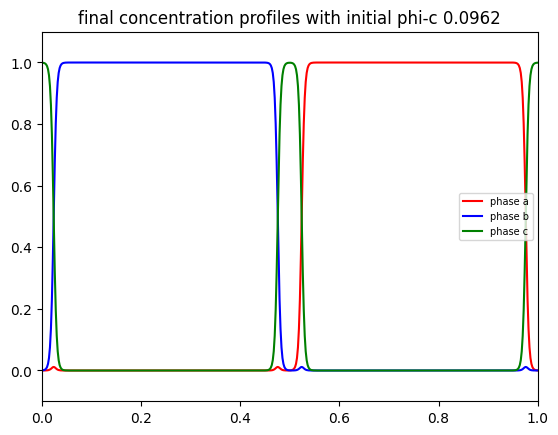

In [168]:
def main_loop(ua, ub, uc):
    for step in range(stepmax):
        ua, ub, uc = pde_solver_FFT(ua, ub, uc)
        #if step%10000==0: print(f"iteration {step} has done, err {err}")
    return ua, ub, uc


lp = LineProfiler()
func = lp(main_loop)
ua, ub, uc = func(ua, ub, uc)
print(ua + ub + uc)
print(jnp.all(ua + ub + uc == 1))#判断全空间上三个组分的浓度是否和为1

concentration_profile(ua, ub, uc, gottitle=True, issavefig=False, show=True)